# TODO: 
## Must
- [x] Rename columns for easier handling
- [ ] Implement cross validation training technique
- [ ] Implement learning curve plot for different model complexities and parameters
- [ ] Implement ensemble methods for classification
- [x] Make neural network classifier hyperparameters adjustable
- [x] Add clustering results as new columns in the pandas dataframe along with the movie details
- [ ] Use clustering metrics
- [x] Create classification experiments framework

## Should

## Nice to do
- [ ] More classification models



# 1. Προετοιμασία δεδομένων

Import τα απατούμενα packages της Python

In [298]:
import pandas as pd

import re

import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colormaps

import torch

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor

from tqdm.notebook import tqdm

from collections import Counter

from neural_network_classifier import OscarClassificationNeuralNetwork, accuracy_fn
# from google.colab import drive
# drive.mount('/content/drive')

## 1.1 Φόρτωση των δεδομένων
Φορτώνουμε τα δεδομένα από το αρχείο `movies.xlsx` σε ένα pandas dataframe.

In [222]:
df = pd.read_excel('movies.xlsx')
pd.set_option('display.max_columns', None)

# Truncate
pd.set_option('display.max_rows', False) # Change False to None to not truncate

Μετονομάζουμε τις στήλες σε πιο χρήσιμα ονόματα αφαιρώντας τα επιπλέον κενά. 

In [223]:
# remove double spaces, leading and trailing spaces and replace them with _ and convert to lowercase
new_names_dict = dict(zip(df.columns, list(x.strip().replace(" ", "_").replace("__", "_").lower() for x in df.columns)))

# replace df columns
df = df.rename(columns=new_names_dict)

## 1.2 Γενική εικόνα των δεδομένων
Βλέπουμε το περιεχόμενο του dataframe εμφανίζοντας τις πρώτες 5 γραμμές.

In [224]:
df.head()

,film,year,script_type,rotten_tomatoes_critics,metacritic_critics,average_critics,rotten_tomatoes_audience,metacritic_audience,rotten_tomatoes_vs_metacritic_deviance,average_audience,audience_vs_critics_deviance,primary_genre,genre,opening_weekend,opening_weekend_($million),domestic_gross,domestic_gross_($million),foreign_gross_($million),foreign_gross,worldwide_gross,worldwide_gross_($million),of_gross_earned_abroad,budget_($million),budget_recovered,budget_recovered_opening_weekend,distributor,imdb_rating,imdb_vs_rt_disparity,release_date_(us),oscar_winners,oscar_detail
0,300,2007,adaptation,60,51,56,89.0,71,18,80,-25,action,"period, action",70885301,70.89,210614939,210.61,245.45,245453242,456068181,456.0,53.82%,65,701.64%,109.05%,NaN,NaN,NaN,"Mar 9, 2007",NaN,NaN
1,3:10 to Yuma,2007,remake,88,76,82,86.0,73,13,80,3,western,western,14035033,14.04,53606916,53.61,16.17,16173815,69780731,70.0,23.18%,50,139.56%,28.07%,NaN,NaN,NaN,"Sep 7, 2007",NaN,NaN
2,30 Days of Night,2007,adaptation,50,53,52,56.0,65,-9,61,-9,horror,horror,15951902,15.95,39568996,39.57,35.53,35526091,75095087,75.0,47.31%,32,234.67%,49.85%,NaN,NaN,NaN,"Oct 19, 2007",NaN,NaN
3,Across the Universe,2007,original screenplay,54,56,55,82.0,73,9,78,-23,musical,musical,3824988,3.82,24343673,24.34,5.02,5023470,29367143,29.0,17.11%,45,65.26%,8.50%,NaN,NaN,NaN,"Oct 12, 2007",NaN,NaN
4,Alien vs. Predator - Requiem,2007,sequel,14,29,22,31.0,45,-14,38,-17,sci-fi,"sci-fi, horror",10059425,10.06,41797066,41.80,87.09,87086650,128883716,129.0,67.57%,40,322.21%,25.15%,NaN,NaN,NaN,"Dec 25, 2007",NaN,NaN


Τα βασικά χαρακτηριστικά του dataframe όπως τον αριθμό των γραμμών και τον τύπο των δεδομένων της κάθε στήλης.

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402 entries, 0 to 1401
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   film                                    1402 non-null   object 
 1   year                                    1402 non-null   int64  
 2   script_type                             1402 non-null   object 
 3   rotten_tomatoes_critics                 1401 non-null   object 
 4   metacritic_critics                      1402 non-null   object 
 5   average_critics                         1402 non-null   object 
 6   rotten_tomatoes_audience                1401 non-null   float64
 7   metacritic_audience                     1402 non-null   object 
 8   rotten_tomatoes_vs_metacritic_deviance  1402 non-null   object 
 9   average_audience                        1402 non-null   object 
 10  audience_vs_critics_deviance            1402 non-null   obje

Βασικά στατιστικά των στηλών που περιλαμβάνων αριθμητικούς τύπους δεδομένων όπως τη μέση τιμή και τη κανονική κατανομή.  

In [226]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,1402.0,2012.140514,3.190291,2007.0,2009.0000,2012.000,2015.0000,2017.00
rotten_tomatoes_audience,1401.0,62.122769,17.435737,17.0,49.0000,62.000,76.0000,98.00
opening_weekend_($million),1402.0,23.200357,28.547541,0.0,6.6025,14.200,28.5975,247.97
domestic_gross_($million),1402.0,74.058024,87.389737,0.0,21.0900,44.045,92.5900,936.66
worldwide_gross_($million),1402.0,173.008302,233.859025,0.0,38.0000,88.690,208.7500,2781.50
distributor,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
imdb_rating,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
imdb_vs_rt_disparity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Κάποιες επιπλέον ιδιότητες του dataframe συμπεριλαμβανομένου και του τύπου δεδομένων `object`

In [227]:
df.describe(include='object').T

,count,unique,top,freq
film,1402,1396,Big Miracle,2
script_type,1402,17,original screenplay,546
rotten_tomatoes_critics,1401,102,93,29
metacritic_critics,1402,90,51,39
average_critics,1402,196,64,25
metacritic_audience,1402,78,66,50
rotten_tomatoes_vs_metacritic_deviance,1402,82,-1,58
average_audience,1402,116,58,45
audience_vs_critics_deviance,1402,78,-5,54
...,...,...,...,...


# 2. Καθαρισμός δεδομένων
Ελέγχουμε και αντιμετωπίζουμε **missing values**, **outliers** και **διπλότυπα**.


## 2.1 Έλεγχος για διπλότυπα

Ελέγχουμε για διπλότυπα με το όνομα της ταινίας.

In [228]:
df[df.duplicated(subset=['film'], keep=False)]

,film,year,script_type,rotten_tomatoes_critics,metacritic_critics,average_critics,rotten_tomatoes_audience,metacritic_audience,rotten_tomatoes_vs_metacritic_deviance,average_audience,audience_vs_critics_deviance,primary_genre,genre,opening_weekend,opening_weekend_($million),domestic_gross,domestic_gross_($million),foreign_gross_($million),foreign_gross,worldwide_gross,worldwide_gross_($million),of_gross_earned_abroad,budget_($million),budget_recovered,budget_recovered_opening_weekend,distributor,imdb_rating,imdb_vs_rt_disparity,release_date_(us),oscar_winners,oscar_detail
681,That's My Boy,2012,original screenplay,20,31,26,53.0,54,-1,54,-28,NaN,comedy,13453714,13.45,36931089,36.93,20.79,20788004,57719093,58.00,36.02%,70,82.46%,19.22%,NaN,NaN,NaN,"Jun 15, 2012",NaN,NaN
682,That's My Boy,2012,original screenplay,20,31,26,53.0,54,-1,54,-28,NaN,comedy,13453714,13.00,36931089,37.00,20.79,20788004,57719093,58.00,36.02%,70,82.46,18.57%,NaN,NaN,NaN,"Jun 15, 2012",NaN,NaN
703,Big Miracle,2012,adaptation,74,61,68,64.0,59,5,62,6,NaN,romance,7760205,7.76,20157300,20.16,4.56,4561915,24719215,25.00,18.45%,40,61.80%,19.40%,NaN,NaN,NaN,"Feb 3, 2012",NaN,NaN
704,Big Miracle,2012,adaptation,74,61,68,64.0,59,5,62,6,NaN,romance,7760205,8.00,20157300,20.00,4.56,4561915,24719215,25.00,18.45%,40,61.8,20.00%,NaN,NaN,NaN,"Feb 3, 2012",NaN,NaN
709,Premium Rush,2012,original screenplay,76,66,71,60.0,68,-8,64,7,NaN,"action, crime, thriller",6030164,6.00,20275446,20.00,10.81,10808153,31083599,31.00,34.77%,35,88.81,17.14%,NaN,NaN,NaN,"Aug 24, 2012",NaN,NaN
710,Premium Rush,2012,original screenplay,76,66,71,60.0,68,-8,64,7,NaN,"action, crime, thriller",6030164,6.03,20275446,20.28,10.81,10808153,31083599,31.00,34.77%,35,88.81%,17.23%,NaN,NaN,NaN,"Aug 24, 2012",NaN,NaN
713,The Master,2012,original screenplay,85,86,86,59.0,69,-10,64,22,NaN,drama,736311,0.74,16377274,16.38,11.88,11880786,28258060,28.00,42.04%,32,88.31%,2.30%,NaN,NaN,NaN,"Sep 21, 2012",NaN,NaN
714,The Master,2012,original screenplay,85,86,86,59.0,69,-10,64,22,NaN,drama,736311,1.00,16377274,16.00,11.88,11880786,28258060,28.00,42.04%,32,88.31,3.13%,NaN,NaN,NaN,"Sep 21, 2012",NaN,NaN
1001,The Good Dinosaur,2015,original screenplay,77,66,72,66.0,70,-4,68,4,NaN,Adventure,39155217,39.00,123087120,123.09,209.12,209120551,332207671,332.21,62.95%,200,166%,19.58%,NaN,NaN,NaN,"Nov 25, 2015",NaN,NaN
1062,The Big Short,2015,adaptation,87,81,84,89.0,89,0,89,-5,NaN,drama,10531026,10.53,60900477,60.90,41.80,41800000,102700477,103.00,40.70%,28,366.79%,37.61%,NaN,NaN,NaN,"December 11, 2015",NaN,NaN


Διαγραφή διπλότυπων

In [229]:
df = df.drop_duplicates(subset=['film'])

## 2.2 Απών τιμές
Ελέγχουμε για τυχών απών τιμές όπως `NaN` και `-`.

In [230]:
# Print lines with missing values
df[df['rotten_tomatoes_critics'].isnull() | df['rotten_tomatoes_audience'].isnull() | df['genre'].isnull() | df.isin(['-']).any(axis=1)]

,film,year,script_type,rotten_tomatoes_critics,metacritic_critics,average_critics,rotten_tomatoes_audience,metacritic_audience,rotten_tomatoes_vs_metacritic_deviance,average_audience,audience_vs_critics_deviance,primary_genre,genre,opening_weekend,opening_weekend_($million),domestic_gross,domestic_gross_($million),foreign_gross_($million),foreign_gross,worldwide_gross,worldwide_gross_($million),of_gross_earned_abroad,budget_($million),budget_recovered,budget_recovered_opening_weekend,distributor,imdb_rating,imdb_vs_rt_disparity,release_date_(us),oscar_winners,oscar_detail
504,Paranormal Activity 2,2010,sequel,NaN,53,53,NaN,58,-58,58,-5,NaN,horror,40670000,40.67,84750000,84.75,92.76,92760000,"177,510,000",177.51,52.26%,3,5917.00%,1355.67%,NaN,NaN,NaN,"Oct 22, 2010",NaN,NaN
930,Deliver Us From Evil,2014,adaptation,28,40,34,42.0,59,-17,51,-17,NaN,NaN,9740471,9.74,30477122,30.48,57.36,57360693,87937815,88.00,65.23%,30,293.13%,32.47%,NaN,NaN,NaN,"Jul 2, 2014",NaN,NaN
1268,Baahubali 2: The Conclusion,2017,sequel,100,-,-,87.0,85,2,86,-,NaN,"action, adventure",10430497,10.43,20186659,20.19,121.32,121319777,141506436,141.51,85.73%,39,362.84%,26.74%,NaN,NaN,NaN,"Apr 28, 2017",NaN,NaN
1272,Beatriz At Dinner,2017,original screenplay,75,68,72,56.0,52,4,54,18,NaN,comedy,141959,0.14,7115854,7.12,0.00,0,7115854,7.12,0.00%,-,-,-,NaN,NaN,NaN,"Jun 9, 2017",NaN,NaN
1317,Let there be Light,2017,original screenplay,60,-,-,78.0,55,23,67,-,NaN,drama,1729535,1.73,7184198,7.18,0.00,0,7184198,7.18,0.00%,3,239.47%,57.65%,NaN,NaN,NaN,"Nov 10, 2017",NaN,NaN
1322,Lowriders,2017,original screenplay,55,57,56,63.0,-,-,-,-,NaN,drama,2403885,2.40,6179955,6.18,0.00,0,6179955,6.18,0.00%,1,686.66%,267.10%,NaN,NaN,NaN,"May 12, 2017",NaN,NaN
1325,Megan Leavey,2017,based on a true story,84,66,75,83.0,65,18,74,1,NaN,drama,3810867,3.81,13406883,13.41,0.00,0,13406883,13.41,0.00%,-,-,-,NaN,NaN,NaN,"Jun 9, 2017",NaN,NaN
1367,The Glass Castle,2017,"adaptation, based on a true story",49,56,53,74.0,63,11,69,-16,NaN,drama,4678548,4.68,17273059,17.27,4.50,4497986,21771045,21.77,20.66%,-,-,-,NaN,NaN,NaN,"Aug 11, 2017",NaN,NaN
1375,The Man Who Invented Christmas,2017,"adaptation, based on a true story",80,60,70,84.0,61,23,73,-3,NaN,drama,1353297,1.35,4664004,4.66,0.00,0,4664004,4.66,0.00%,-,-,-,NaN,NaN,NaN,"Nov 22, 2017",NaN,NaN
1388,Til Death Do Us Part,2017,original screenplay,-,-,-,64.0,-,-,-,-,NaN,thriller,1527289,1.53,3455267,3.46,0.00,0,3455267,3.46,0.00%,-,-,-,NaN,NaN,NaN,"Sep 29, 2017",NaN,NaN


Διαγράφούμε τις γραμμές που έχουν απών τιμές

In [231]:
# Drop lines that contain null or invalid values
df = df.dropna(subset=['genre', 'rotten_tomatoes_critics', 'rotten_tomatoes_audience'])
df = df[~df.isin(['-']).any(axis=1)]

## 2.3 Έλεγχος για outliers
Ελέγχουμε και διορθώνουμε τυχών outliers με πρώτο βήμα να μετατρέψουμε τις συμβολοσειρές σε κανονικές αριθμητικές μεταβλητές float ή integer. Επίσης μετατρέπουμε την στήλη `oscar_winners` σε 0 ή 1.

In [232]:
# Remove invalid characters from numerical strings
df = df.apply(lambda x: x.replace(',','', regex=True) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'oscar_winners','oscar_detail'] else x, axis=0)
df = df.apply(lambda x: x.replace('%','', regex=True) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'oscar_winners','oscar_detail'] else x, axis=0)

# Convert strings to numbers
df = df.apply(lambda x: pd.to_numeric(x) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'oscar_winners','oscar_detail'] else x, axis=0)

# Convert Oscar Winners to 1 hot encoding
df['oscar_winners'] = df["oscar_winners"].notnull().astype("int")

In [233]:
# Detect critic values outside normal range
df[(df['rotten_tomatoes_audience'] < 0) | (df['rotten_tomatoes_audience'] > 100) | (df['rotten_tomatoes_critics'] < 0) | (df['rotten_tomatoes_critics'] > 100)
   | (df['metacritic_critics'] < 0 ) | (df['metacritic_critics'] > 100) |  (df['metacritic_audience'] < 0 ) | (df['metacritic_audience']) > 100].sum()

film                                        0
year                                        0
script_type                                 0
rotten_tomatoes_critics                     0
metacritic_critics                          0
average_critics                           0.0
rotten_tomatoes_audience                  0.0
metacritic_audience                         0
rotten_tomatoes_vs_metacritic_deviance      0
average_audience                          0.0
audience_vs_critics_deviance                0
primary_genre                               0
                                         ... 
worldwide_gross                             0
worldwide_gross_($million)                0.0
of_gross_earned_abroad                    0.0
budget_($million)                         0.0
budget_recovered                          0.0
budget_recovered_opening_weekend          0.0
distributor                               0.0
imdb_rating                               0.0
imdb_vs_rt_disparity              

Υπολογίζουμε τις τιμές που αφορούν οικονομικά με τιμές άλλων στηλών όπου είναι εφικτό.

In [234]:
df.loc[(df['opening_weekend_($million)'] == 0), 'opening_weekend_($million)'] = df.loc[(df['opening_weekend_($million)'] == 0), 'opening_weekend'] / 1000
df.loc[(df['domestic_gross_($million)'] == 0), 'domestic_gross_($million)'] = df.loc[(df['domestic_gross_($million)'] == 0), 'domestic_gross'] / 1000
df.loc[(df['foreign_gross_($million)'] == 0), 'foreign_gross_($million)'] = df.loc[(df['foreign_gross_($million)'] == 0), 'foreign_gross'] / 1000
df.loc[(df['worldwide_gross_($million)'] == 0), 'worldwide_gross_($million)'] = df.loc[(df['worldwide_gross_($million)'] == 0), 'worldwide_gross'] / 1000

Διορθώνουμε άλλες τιμές που βρίσκονται εκτός φυσιολογικού ορίου.

In [235]:
Q1 = df['budget_($million)'].quantile(0.25)
Q3 = df['budget_($million)'].quantile(0.75)

IQR = Q3 - Q1
threshold = 5

outliers = df[(df['budget_($million)'] < Q1 - threshold * IQR) | (df['budget_($million)'] > Q3 + threshold * IQR)]
outliers

df.at[outliers['budget_($million)'].index[0], 'budget_($million)'] = df.at[outliers['budget_($million)'].index[0], 'budget_($million)'] / 1000

In [236]:
# Conver ' of Gross earned abroad' values to 0-1 range since '%' is removed
df['of_gross_earned_abroad'] = df['of_gross_earned_abroad'].apply(lambda s: s / 100)

Σβήνουμε όποιες γραμμές έχουν budget 0 και δεν μπορούν να διορθωθούν

In [237]:
df = df[df['foreign_gross_($million)'] != 0]
df = df[df['of_gross_earned_abroad'] != 0]

Μία στατιστική εικόνα του dataframe με διορθωμένες αριθμητικές τιμές.

In [238]:
df = df.reset_index()
df = df.drop(['index'],axis=1)
df.describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
year,1333.00,2011.95,3.11,2007.00,2009.00,2012.00,2015.00,2017.00
rotten_tomatoes_critics,1333.00,52.86,27.47,0.00,28.00,53.00,78.00,99.00
metacritic_critics,1333.00,53.48,17.34,9.00,41.00,53.00,66.00,100.00
average_critics,1333.00,53.40,22.09,6.00,35.00,53.00,71.00,99.00
rotten_tomatoes_audience,1333.00,62.06,17.23,19.00,49.00,62.00,76.00,98.00
metacritic_audience,1333.00,62.96,13.38,9.00,54.00,64.00,73.00,92.00
rotten_tomatoes_vs_metacritic_deviance,1333.00,-0.89,11.84,-52.00,-9.00,-1.00,6.00,45.00
average_audience,1333.00,62.74,14.24,15.50,52.50,63.00,73.00,93.00
audience_vs_critics_deviance,1333.00,-9.48,13.77,-48.00,-20.00,-9.00,0.00,33.00
...,...,...,...,...,...,...,...,...


# 3. Εξερεύνηση χαρακτηριστικών
Εξερευνούμε τα χαρακτηριστικά των δεδομένων εκτελώντας αλγόριθμούς υπολογισμού συσχετίσεων και PCA

## 3.1 Προεπεξεργασία των δεδομένων

Μετατροπή των στηλών `script_typr` και `genre` σε 1 hot encoding

In [239]:
# Make a copy of dataframe
df_cl = df

In [240]:
# Convert strings to lowercase
df_cl['script_type'] = df_cl['script_type'].str.lower()

# Extract all unique script type names
script_types = df_cl['script_type'].unique()

# Split strings and remove trailing spaces
types = []
for string in script_types:
    types.append(re.split(' / |, ',string))
script_types = [j.strip() for sub in types for j in sub]

#Convert to set to remove dublicates
unique_script_types = set(script_types)

# Insert columns for each coresponding script type
for i, item in enumerate(unique_script_types):
    # df.insert(i+1, 'st_'+item, 0)
    # df.insert(-1, 'st_'+item, 0)
    df_cl.insert(i, 'st_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df_cl.index:
    for script in unique_script_types:
        if script in df_cl.at[i, 'script_type']:
            df_cl.at[i, 'st_'+script] = 1

# Drop script type and primary genre columns from dataframe
df_cl = df_cl.drop(['script_type'], axis=1)

In [241]:
# Convert genres to lower to avoid possible dublication
df_cl['genre'] = df_cl['genre'].str.lower()
genres = df_cl['genre'].unique()

# Split strings and remove trailing spaces
unique_genres = []
for string in genres:
    unique_genres.append(re.split(', |. ',string))
genre_types = [j.strip() for sub in unique_genres for j in sub]

#Convert to set to remove dublicates
genre_types = set(genre_types)

# Remove invalid values
genre_types.remove('')
genre_types.remove('adventur')
genre_types.remove('biograph')
genre_types.remove('comed')
genre_types.remove('crim')
genre_types.remove('documentar')
genre_types.remove('dram')
genre_types.remove('famiily')
genre_types.remove('famil')
genre_types.remove('fantas')
genre_types.remove('horro')
genre_types.remove('musi')
genre_types.remove('music')
genre_types.remove('myster')
genre_types.remove('romanti')
genre_types.remove('sci-f')
genre_types.remove('sport')
genre_types.remove('thriler')
genre_types.remove('thrille')

# Insert columns for each coresponding script type
for i, item in enumerate(genre_types):
    # df.insert(i+9, 'gen_'+item, 0)
    df_cl.insert(i, 'gen_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df_cl.index:
    for genr in genre_types:
        if genr in df_cl.at[i, 'genre']:
            df_cl.at[i, 'gen_'+genr] = 1

# Drop original genre column
df_cl = df_cl.drop(['genre'], axis=1)

In [242]:
# Drop unecessary primary genre
df_cl = df_cl.drop(['primary_genre'], axis=1)

Μία γενική εικόνα του dataframe μετά τους μετασχηματισμούς

In [243]:
df_cl.head().T

,0,1,2,3,4
gen_fantasy,0,0,0,0,0
gen_crime,0,0,0,0,0
gen_war,0,0,0,0,0
gen_biography,0,0,0,0,0
gen_sci-fi,0,0,0,0,1
gen_adventure,0,0,0,0,0
gen_comedy,0,0,0,0,0
gen_western,0,1,0,0,0
gen_drama,0,0,0,0,0
...,...,...,...,...,...


## 3.2 Ανάλυση συσχετίσεων

### 3.2.1 Συσχέτιση χαρακτηριστικών με τη στήλη `oscar_winners`
Υπολογίζουμε την συσχέτιση με τη στήλη `oscar_winners` για να διαπιστώσουμε ποιο χαρακτηριστικό συμβάλει περισσότερο στο αν έχει πάρει oscar μία ταινία. Χωρίς έκπληξη διαπιστώνουμε ότι οι κριτικές έχουν τη μεγαλύτερη βαρύτητα όμως γενικά οί συσχετίσεις είναι μικρές.

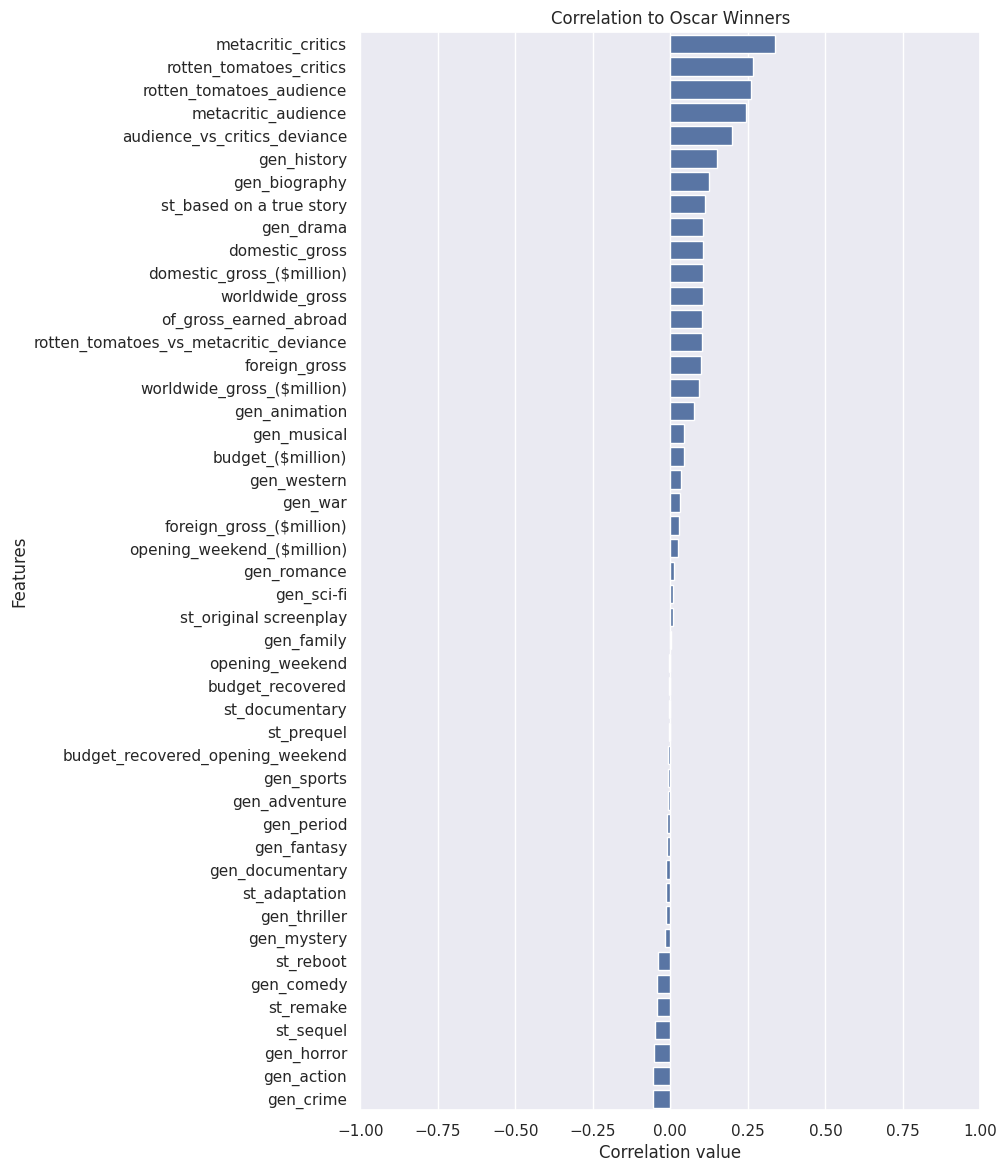

In [244]:
# remove non relevant columns
# df_cl_corr = df_cl.drop(['Film', 'Year','Distributor', 'IMDb Rating', 'IMDB vs RT disparity', 'Release Date (US)','Oscar Detail'], axis=1)

# Remove non relevant columns and average critics columns
df_cl_corr = df_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail' , 'average_critics', 'average_audience'], axis=1)

# Calculate correlation values and grab last row
corr = df_cl_corr.corr()
last_row = pd.DataFrame(corr.iloc[-1, :-1]).sort_values(by='oscar_winners', ascending=False)

sns.set_theme()
plt.figure(figsize=(8, 14))
plt.title('Correlation to Oscar Winners')
plt.xlabel('Correlation value')
plt.ylabel('Features')
plt.xlim(-1, 1)
sns.barplot(data=last_row, x='oscar_winners', y=last_row.index)
plt.show()

### 3.2.2 Υπολογισμός Variance Inflation Factor
Υπολογίζουμε το Variance Inflation Factor των χαρακτηριστικών για να διαπιστώσουμε αν υπάρχει φαινόμενο multicollinearity. Σύμφωνα με το αποτέλεσμα υπάρχει τεράστιο φαινόμενο multicollinearity καθώς κάποιες τιμές φτάνουν το άπειρο! 


In [245]:
# TODO: Strategy for dealing with high multicollinearity ?

# Drop labels from set
X = df_cl_corr.drop(['oscar_winners'], axis=1)
  
# VIF dataframe
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
vif_data["VIF"] = vif_data["VIF"].round(2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# pd.options.display.float_format = '{:.2f}'.format
vif_data

/home/mike/.local/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
33,rotten_tomatoes_vs_metacritic_deviance,inf
32,metacritic_audience,inf
31,rotten_tomatoes_audience,inf
29,rotten_tomatoes_critics,11201.77
30,metacritic_critics,10263.70
41,worldwide_gross,3548.80
34,audience_vs_critics_deviance,3465.94
40,foreign_gross,1601.11
37,domestic_gross,628.22
...,...,...


### 3.2.3 Πίνακας συσχέτισης
Υπολογίζουμε τον πίνακα συσχέτισης μεταξύ όλων των χαρακτηριστικών.

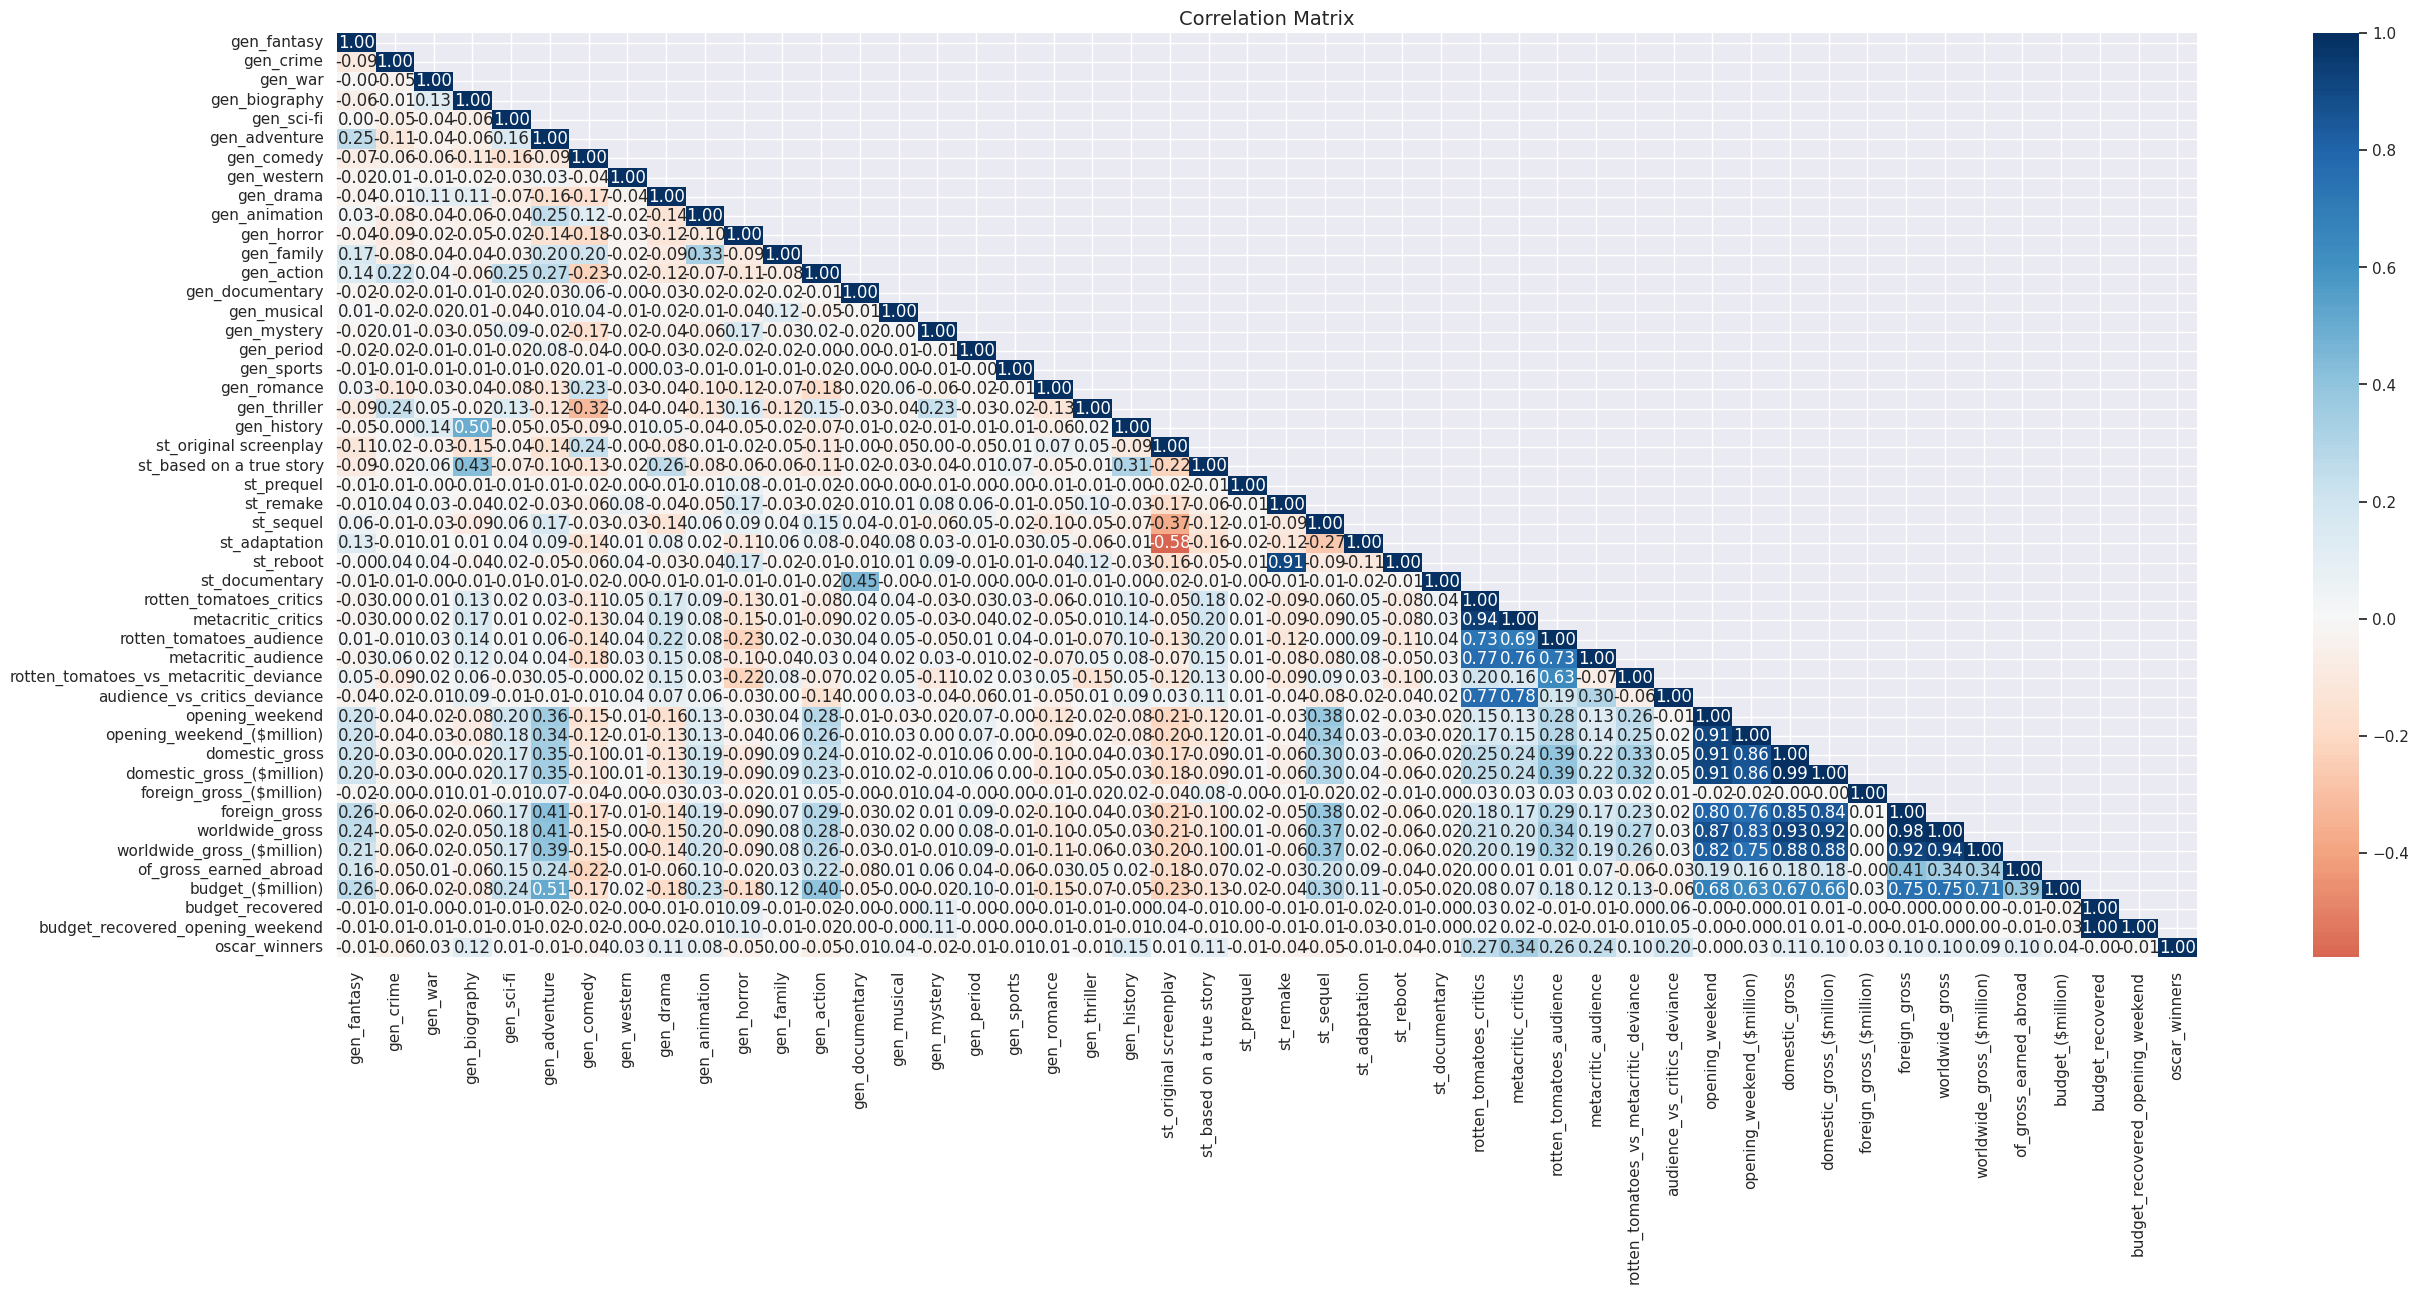

In [246]:
# Plot correlation matrix
# df_cl_corr_less = df_cl_corr[['Metacritic  critics', 'Rotten Tomatoes  critics','Rotten Tomatoes Audience ','Metacritic Audience ', 'Oscar Winners']]
df_cl_corr_less = df_cl_corr
corr_mat = df_cl_corr_less.corr()

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask, k=1)] = True

sns.set_theme()
plt.figure(figsize=(30, 12))
sns.heatmap(corr_mat, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f')
plt.title('Correlation Matrix', fontsize=14)
plt.show()

In [247]:
y = df_cl[['oscar_winners']]
# meta = df_cl['film'] 

### 3.2.4 Pairplot μεταξύ κάποιων σημαντικών χαρακτηριστικών.

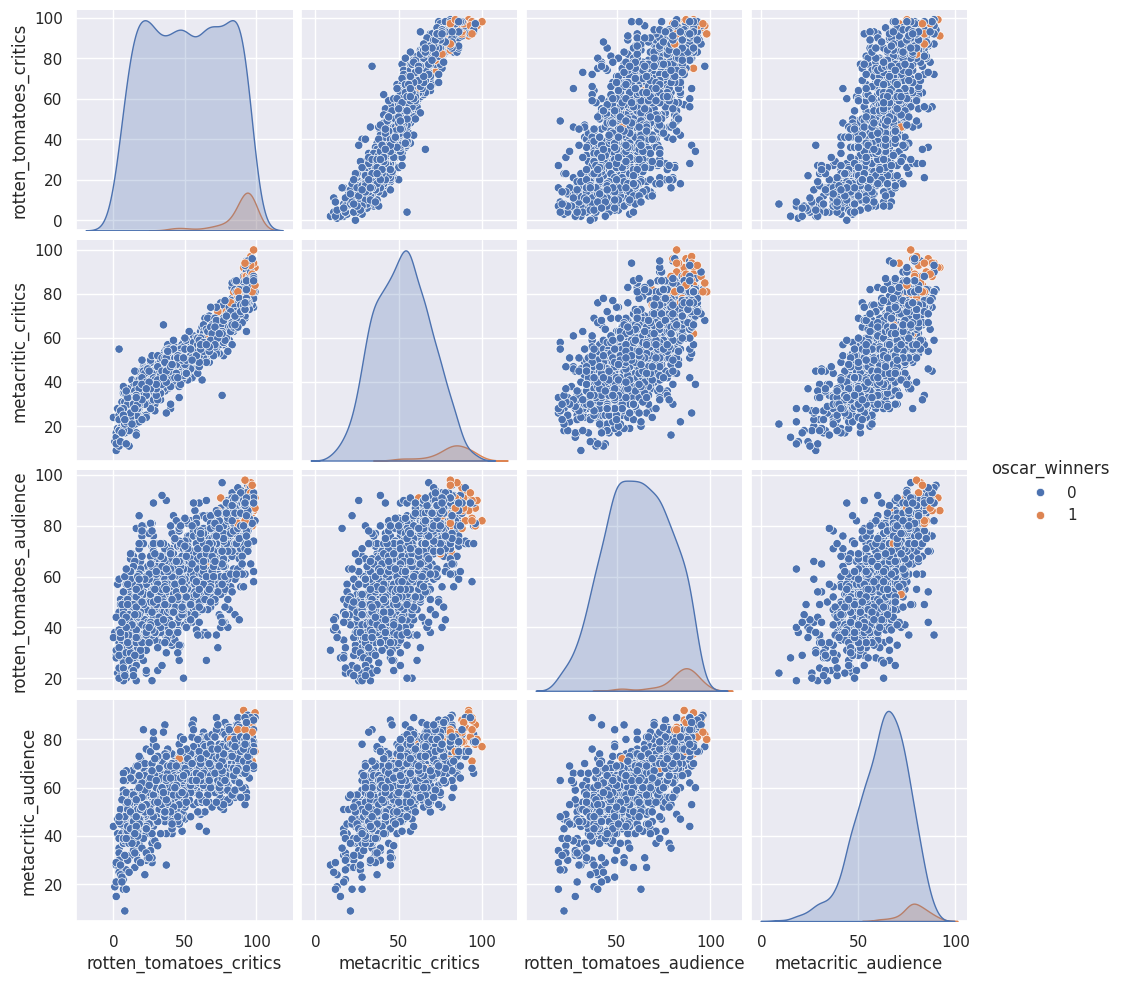

In [248]:
pairplt = df_cl[['rotten_tomatoes_critics', 'metacritic_critics', 'rotten_tomatoes_audience', 'metacritic_audience']]
sns.pairplot(pd.concat([pairplt, y], axis=1), hue='oscar_winners')
plt.show()

## 3.3 Principle Components Analysis
Εκτελούμε τον αλγόριθμο PCA για να δούμε αν τα δεδομένα μπορούν να αναπαρασταθούν σε λιγότερες διαστάσεις.

Επιλέγουμε τα πιο σημαντικά χαρακτηριστικά και υπολογίζουμε τις πιο σημαντικές διαστάσεις των Principal Components. Από το γράφημα διαπιστώνουμε ότι τα δεδομένα δεν μπορούν εύκολα να αναπαρασταθούν σε λιγότερες διαστάσεις διότι η πληροφορία είναι ομοιόμορφα μοιρασμένη.

Text(0.5, 1.0, 'Scree plot')

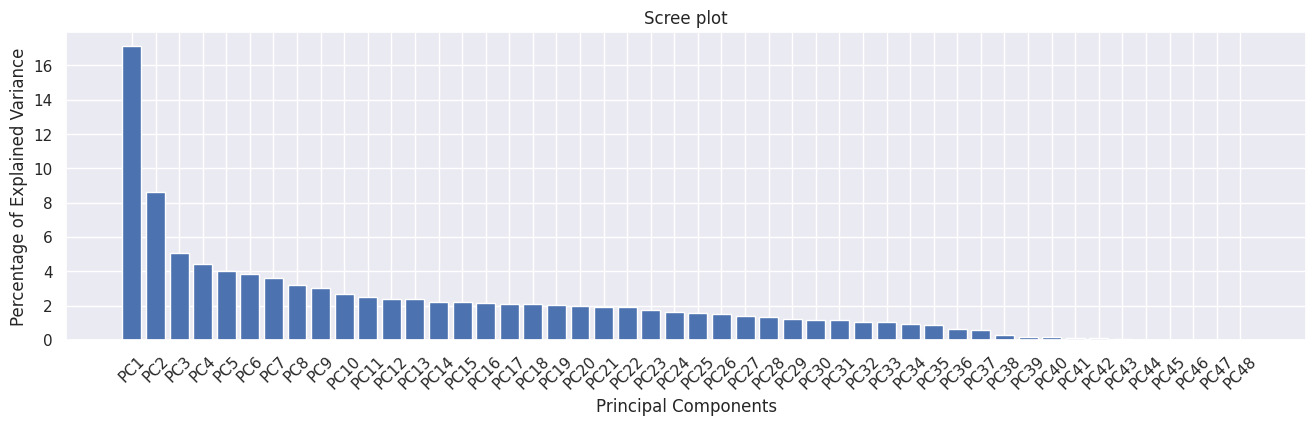

In [249]:
# Select features for PCA analysis
# x = df_cl[['rotten_tomatoes_critics', 'metacritic_critics', 'average_critics', 'rotten_tomatoes_audience', 'metacritic_audience', 'average_audience', 'audience_vs_critics_deviance','domestic_gross', 'foreign_gross', 'worldwide_gross', 'of_gross_earned_abroad']]
x = df_cl_corr_less
# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_df = pd.concat([principal_df, df[['oscar_winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(16,4))
plt.xticks(rotation=45)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')

Text(0, 0.5, 'Cumulative explanied variance')

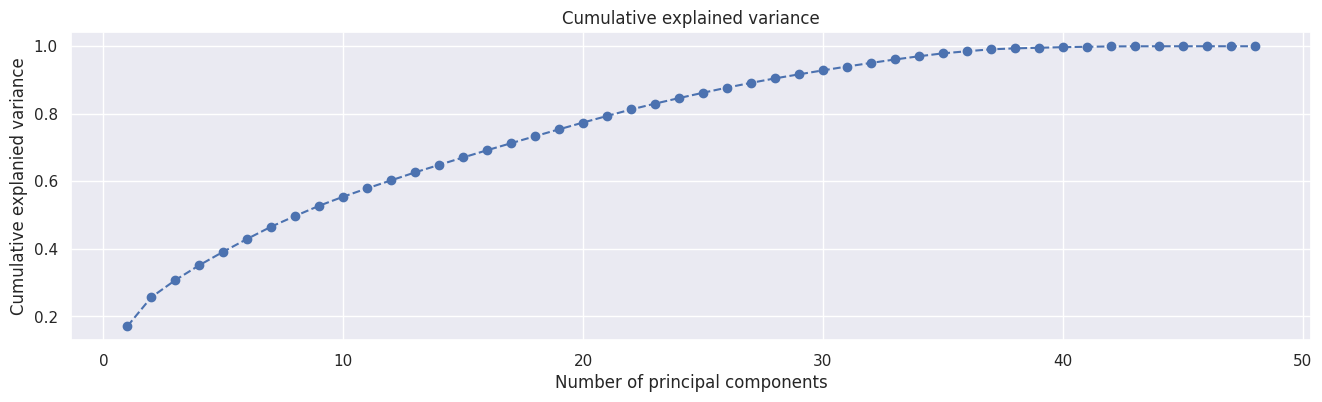

In [250]:
sns.set_theme()
plt.figure(figsize= (16,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explanied variance')

Μπορούμε να διακρίνουμε μία μικρή συσταδοποίηση των oscar winners κάνοντας plot τα πρώτα 2 principal components αλλά λόγω της πυκνότητας δεν έχουμε τα καλά αποτελέσματα.

<Axes: xlabel='PC1 - 17.11%', ylabel='PC2 - 8.6%'>

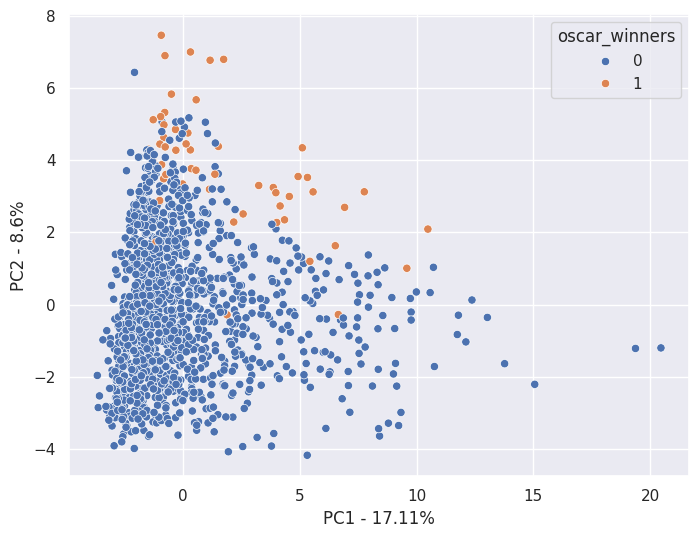

In [251]:
sns.set_theme()
plt.figure(figsize=(8, 6))
plt.xlabel(f'PC1 - {per_var[0]}%')
plt.ylabel(f'PC2 - {per_var[1]}%')
sns.scatterplot(data=final_df, x="PC1", y='PC2', hue='oscar_winners')

Επαναϋπολογίζουμε τα principal components και αυτή τη φορά κρατάμε τα n πρώτα πιο σημαντικά.

In [252]:
# Calculate PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

# Concat PCA results to dataframe
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.columns = [f'PC{x+1}' for x in principal_components_df.columns]
df_cl = pd.concat([df_cl, principal_components_df], axis=1)

# 4. Συσταδοποίηση

## 4.1 KMeans
Εκτελούμε τον αλγόριθμο συσταδοποίησης KMeans σε επιλεγμένα χαρακτηριστικά.

Πρώτα χρησιμοπιούμε τη μέθοδο **Elbow** για να βρούμε τον καλύτερο αριθμό συστάδων για τα χαρακτηριστικά που επιλέξαμε.

In [253]:
#PCA features
df_kmeans_pca = df_cl[['PC1', 'PC2']]
# Select features
df_kmeans = df_cl[['metacritic_critics','rotten_tomatoes_critics']]

In [254]:
inertia = []
for i in range(2,11):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans_pca.fit(principal_components)
    inertia.append(kmeans_pca.inertia_)

Text(0.5, 1.0, 'Elbow method graph')

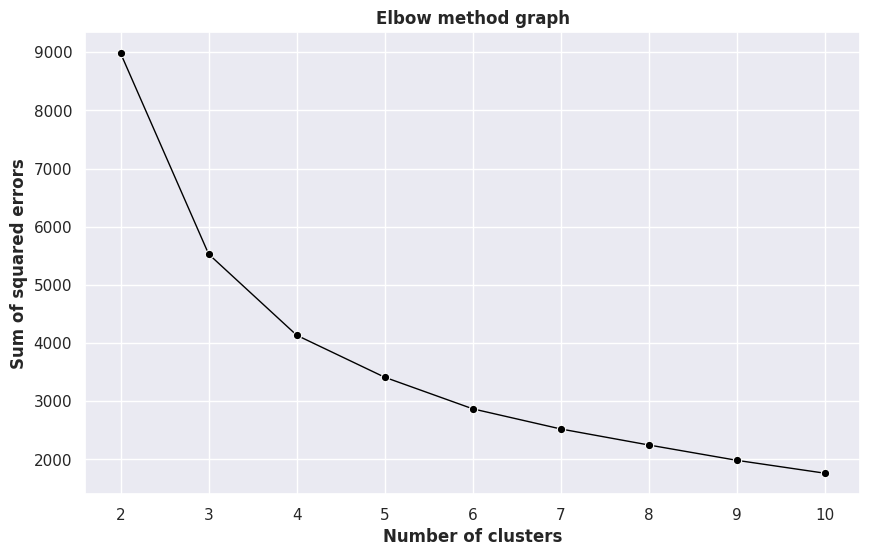

In [255]:
plt.figure(figsize=(10,6))
sns.set_theme()
ax = sns.lineplot(x = range(2, 11),
             y = inertia,
             marker='o', markerfacecolor='black',
             color='black', linewidth=1)


ax.set(title='Elbow method graph', xlabel='Number of clusters', ylabel='Sum of squared errors')
ax.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})
ax.set_title(ax.get_title(), fontdict={'weight': 'bold'})

Εκτελούμε την μεθοδο KMeans συσταδοποίηση με τον αριθμό των συστάδων που βρήκαμε παραπάνω.

In [256]:
# Select features for clustering
df_kmeans_pca = df_cl[['PC1', 'PC2']]
df_kmeans = df_cl[['metacritic_critics', 'rotten_tomatoes_critics']]


# Calculate KMeans clusters for PCA
kmeans_pca = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=42)
kmeans_pca.fit(df_kmeans_pca)

# Calculate KMeans clusters
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=42)
kmeans.fit(df_kmeans)


#Append clusters to dataframe
df_cl['kmeans_pca'] = kmeans_pca.labels_
df_cl['kmeans'] = kmeans.labels_

# Count clusters
kmeans_dict_pca = dict(Counter(kmeans.labels_))
kmeans_dict = dict(Counter(kmeans.labels_))


In [257]:
#Count Oscar winners in each cluster
kmeans_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], df_cl['kmeans']):
    if cluster not in kmeans_oscars:
        kmeans_oscars[cluster] = 0
    kmeans_oscars[cluster] += oscar

kmeans_oscars

{1: 4, 2: 47, 3: 3, 0: 0}

Στο γράφημα μπάρας φαίνεται ο αριθμός των στοιχείων και ο αριθμός των oscar με κόκκινο σε κάθε συστάδα.

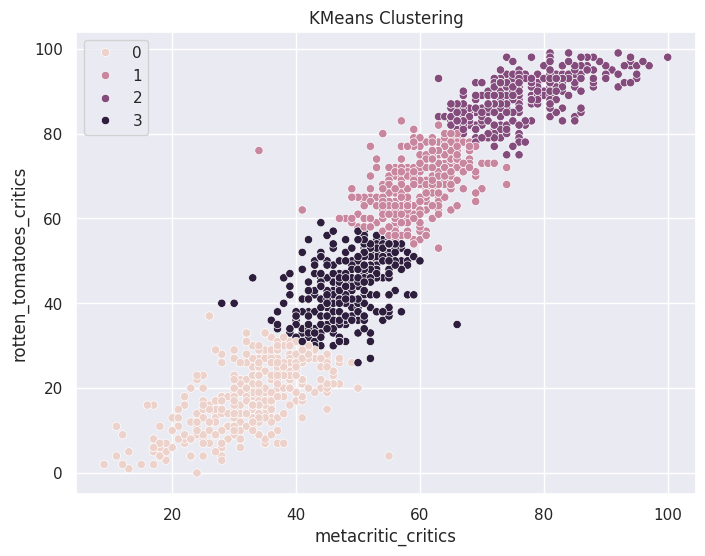

In [258]:
sns.set_theme()
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_cl, x='metacritic_critics', y='rotten_tomatoes_critics', hue='kmeans')
plt.title('KMeans Clustering')
plt.xlabel('metacritic_critics')
plt.ylabel('rotten_tomatoes_critics')
plt.legend()
plt.show()

## 4.2 DBSCAN
Εκτελούμε τον αλγόριθμο συσταδοποίησης DBSCAN σε επιλεγμένα χαρακτηριστικά.

In [259]:
# Select columns for DBSCAN
df_dbscan = df_cl[['rotten_tomatoes_critics', 'metacritic_critics', 'rotten_tomatoes_audience', 'metacritic_audience', 'oscar_winners'] ]

X_dbscan = df_dbscan.drop(['oscar_winners'], axis=1)

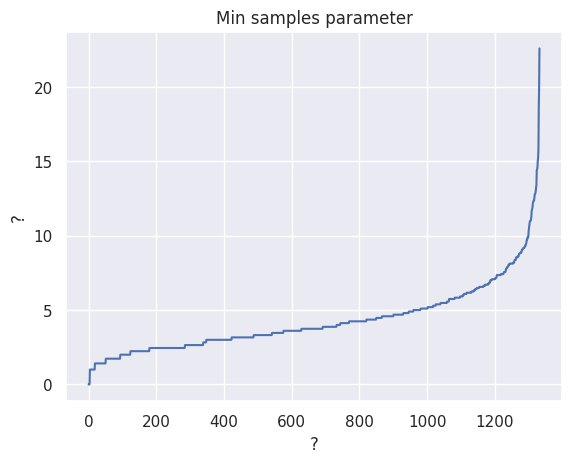

In [260]:
# Find min samples parameter
neighbors = NearestNeighbors(n_neighbors=8)
neighbors_fit = neighbors.fit(X_dbscan)
distances, indices = neighbors_fit.kneighbors(X_dbscan)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title('Min samples parameter')
plt.xlabel('?')
plt.ylabel('?')
plt.show()

In [261]:
# Calculate dbscan clusters
dbscan = DBSCAN(eps=10, min_samples=8).fit(X_dbscan)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

df_cl['dbscan'] = dbscan.labels_

labels_list = dbscan.labels_.tolist()
n_noise_ = labels_list.count(-1)

print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

Estimated number of clusters: 2
Estimated number of noise points: 83


In [262]:
dbscan_dict = dict(Counter(dbscan.labels_))
dbscan_dict

{0: 1239, 1: 11, -1: 83}

In [263]:
# Count oscar winners in each cluster
dbscan_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], df_cl['dbscan']):
    if cluster not in dbscan_oscars:
        dbscan_oscars[cluster] = 0
    dbscan_oscars[cluster] += oscar

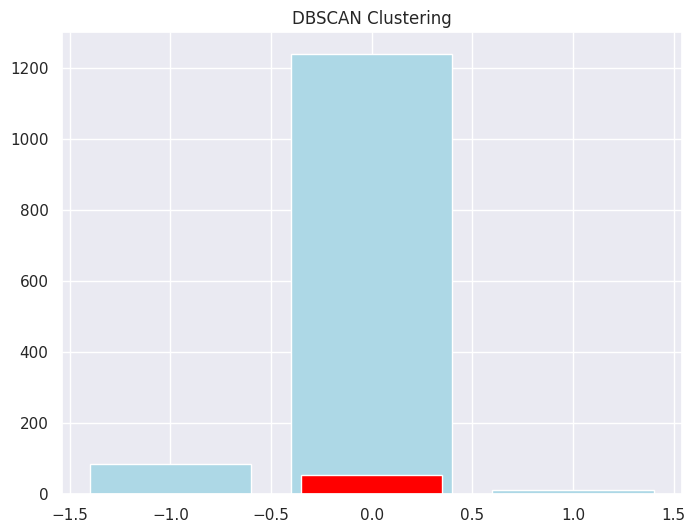

In [264]:
cluster_frequencies = Counter(dbscan.labels_)

labels = []
for item in set(dbscan.labels_):
    labels.append(item)

numbers = []
for key in dbscan_dict:
     numbers.append(dbscan_dict[key])

oscar = []
for key in dbscan_oscars:
     oscar.append(dbscan_oscars[key])
     
sns.set_theme()

plt.figure(figsize=(8,6))
plt.bar(labels, numbers, color='lightblue')
plt.bar(labels, oscar, width=0.7, color='red')
plt.title('DBSCAN Clustering')
plt.show()

## 4.3 Agglomerative Clustering
Εκτελούμε τον αλγόριθμο συσταδοποίησης Agglomerative σε επιλεγμένα χαρακτηριστικά.

In [265]:
# Select features
df_aglm = df_dbscan
X_aglm = X_dbscan

In [266]:
# Calculate agg
agg=AgglomerativeClustering(n_clusters=2, linkage='ward')
agg.fit(X_aglm)

df_cl['agg'] = agg.labels_

In [267]:
agg_dict = dict(Counter(agg.labels_))
agg_dict

{0: 861, 1: 472}

In [268]:
# Count oscar winners in each cluster
agg_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], df_cl['agg']):
    if cluster not in agg_oscars:
        agg_oscars[cluster] = 0
    agg_oscars[cluster] += oscar

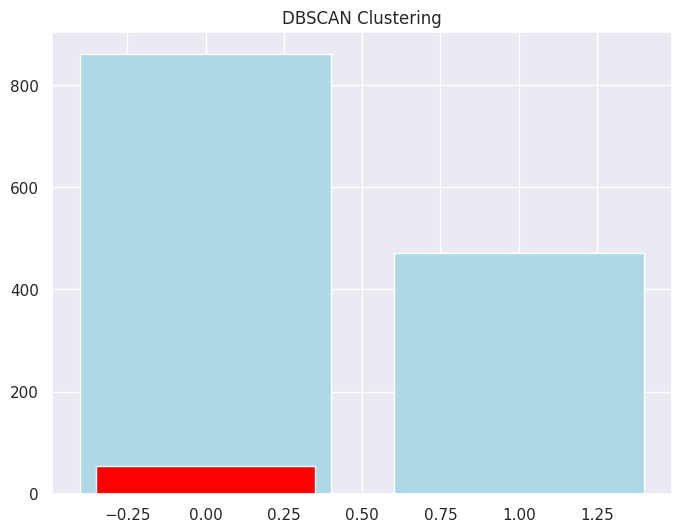

In [354]:
cluster_frequencies = Counter(agg.labels_)

labels = []
for item in set(agg.labels_):
    labels.append(item)

numbers = []
for key in agg_dict:
     numbers.append(agg_dict[key])

oscar = []
for key in agg_oscars:
     oscar.append(agg_oscars[key])
     

sns.set_theme()
plt.figure(figsize=(8,6))
plt.bar(labels, numbers, color='lightblue')
plt.bar(labels, oscar, width=0.7, color='red')
plt.title('DBSCAN Clustering')
plt.show()

## 4.4 Αξιολόγηση αλγόριθμων συσταδοποίησης



# 5. Μοντέλα προβλέψεων

Δοκιμάζουμε διάφορα μοντέλα προβλέψεων εκτελώντας 2 πειράματα.
- 1. Επιλέγουμε να εξισοροπήσουμε τις κλάσεις με διάφορους επιλεγμένους λόγους μη-όσκαρ / όσκαρ. πχ 20:1 10:1 και εκπαιδεύουμε τα μοντέλα με την τεχνική 5-fold cross validation. Για κάθε εκπαίδευση κρατάμε τις βασικές μετρικές αξιολόγησης (recall, f1 score etc.).
- 2. Επιλέγουμε την ισοροποία με τις καλύτερες επιδόσεις για κάθε περίπτωση και εκπαιδεύουμε και δοκιμάζουμε κάθε μοντέλο για Ν επαναλήψεις παίρνοντας το μέσο όρο αξιολογήσεων. Στο τέλος συγκρίνουμε τις επιδόσεις των μοντέλων.

<!-- <img src="../figs/WaveNet-1.png" width=400px height=400px /> -->

<img src="./classification_experiments_small.png"/>

## 5.1 Νευρωνικό δίκτυο

### 5.1.1 Ετοιμασία δεδομένων
Επιλογή χαρακτηριστικών

In [270]:
# remove unecessesary features from dataset
df_nn = df_cl.drop(['film','year','opening_weekend', 'domestic_gross', 
                    'foreign_gross', 'worldwide_gross', 'rotten_tomatoes_vs_metacritic_deviance', 'audience_vs_critics_deviance', 'worldwide_gross_($million)', 'of_gross_earned_abroad', 'average_audience', 'average_critics', 'budget_recovered', 'budget_recovered_opening_weekend', 'distributor','imdb_rating','imdb_vs_rt_disparity','release_date_(us)','oscar_detail','PC1','PC2','kmeans_pca','kmeans','dbscan','agg'], axis=1)

### 5.1.2 Πείραμα 1 - Εύρεση καλύτερου class balance - εκπαίδευση νευρωνικού δικτύου

Εκπαιδεύουμε το μοντέλο για κάθε για κάθε Ν:1 λόγο ισοροποίας κλάσεων με τη μέθοδο 5-fold cross validation.

In [275]:
# Class balance ratios to train
balance_ratios = [20, 16, 12, 8, 4, 3, 2, 1]

data_report_nn = {
    'model': 'Neural network',
    '1_recall': [],
    '1_f1-score' : [],
    'accuracy' : [],
    # 'point_labels': [],
    'n_balance_datasets' : len(balance_ratios)
    }

# Separate oscar winners from non-oscar winners
oscar_movies = df_nn[df_nn['oscar_winners'] == 1]
non_oscar_movies = df_nn[df_nn['oscar_winners'] == 0]

results_nn = []
for ratio in balance_ratios:
    # Select balance
    df_nn_balanced = pd.concat([oscar_movies, non_oscar_movies.sample(n=(ratio * oscar_movies.shape[0]))], axis=0)

    # Prepare dataset for training k-fold splits
    X = df_nn_balanced.drop(['oscar_winners'], axis=1)
    y = df_nn_balanced[['oscar_winners']]

    # Create k-fold splits and stratify classes
    kf = StratifiedKFold(n_splits=5)
    
    # Get train, test splits and train model
    for train_idx, test_idx in tqdm(kf.split(X, y), total=kf.get_n_splits(X, y)):
        train, test = df_nn_balanced.iloc[train_idx], df_nn_balanced.iloc[test_idx]
        # separate labels and convert to tensor
        X_train, y_train = torch.tensor(train.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(train[['oscar_winners']].values, dtype=torch.float32), 
        X_test, y_test = torch.tensor(test.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(test[['oscar_winners']].values, dtype=torch.float32)

        model = OscarClassificationNeuralNetwork(input_features=X_train.shape[1], 
                                                    hidden_layer_input_features = 30,
                                                    hidden_layer_output_features = 30,
                                                    device='cpu',                                               
                                                    learning_rate=0.01)
        
        train_progress = model.fit(accuracy_fn, X_train, y_train, X_test, y_test, epochs=1000, seed=None, verbose=False)
        
        # Test on test split
        y_pred, acc = model.test(accuracy_fn, X_test, y_test)

        report = classification_report(y_test, torch.round(torch.sigmoid(y_pred)), output_dict=True, zero_division=0.0)

        results_nn.append({'balance' : f'{ratio}:1',
                            # 'model_params' : n_params, 
                            'accuracy' : acc,
                            'acc_prog': train_progress,
                            'true' : y_test.to('cpu').numpy(),
                            'preds' : y_pred.to('cpu').numpy(),
                            'pred_oscar_count' : int(y_pred.sum().item()), 
                            'truth_oscar_count' : int(y_test.sum().item()),
                            'classification_report' : report
                        })

    # calculate average metrics between k-folds for a selected balance
    data_report_nn['1_recall'].append(np.average([x['classification_report']['1.0']['precision'] for x in results_nn if x['balance'] == f'{ratio}:1']))
    data_report_nn['1_f1-score'].append(np.average([x['classification_report']['1.0']['f1-score'] for x in results_nn if x['balance'] == f'{ratio}:1']))
    data_report_nn['accuracy'].append(np.average([x['accuracy'] for x in results_nn if x['balance'] == f'{ratio}:1']))

# Add results to experiment A list
exp_a_data = [data_report_nn]

  0%|          | 0/5 [00:00<?, ?it/s]

Test total accuracy: 0.95
Test total accuracy: 0.95
Test total accuracy: 0.96
Test total accuracy: 0.93
Test total accuracy: 0.96


  0%|          | 0/5 [00:00<?, ?it/s]

Test total accuracy: 0.93
Test total accuracy: 0.93
Test total accuracy: 0.95
Test total accuracy: 0.93
Test total accuracy: 0.93


  0%|          | 0/5 [00:00<?, ?it/s]

Test total accuracy: 0.94
Test total accuracy: 0.90
Test total accuracy: 0.94
Test total accuracy: 0.92
Test total accuracy: 0.88


  0%|          | 0/5 [00:00<?, ?it/s]

Test total accuracy: 0.85
Test total accuracy: 0.87
Test total accuracy: 0.96
Test total accuracy: 0.89
Test total accuracy: 0.93


  0%|          | 0/5 [00:00<?, ?it/s]

Test total accuracy: 0.83
Test total accuracy: 0.85
Test total accuracy: 0.87
Test total accuracy: 0.87
Test total accuracy: 0.83


  0%|          | 0/5 [00:00<?, ?it/s]

Test total accuracy: 0.93
Test total accuracy: 0.72
Test total accuracy: 0.84
Test total accuracy: 0.79
Test total accuracy: 0.77


  0%|          | 0/5 [00:00<?, ?it/s]

Test total accuracy: 0.79
Test total accuracy: 0.85
Test total accuracy: 0.94
Test total accuracy: 0.72
Test total accuracy: 0.84


  0%|          | 0/5 [00:00<?, ?it/s]

Test total accuracy: 0.77
Test total accuracy: 0.82
Test total accuracy: 0.86
Test total accuracy: 0.57
Test total accuracy: 0.76


### 5.1.2 Πείραμα 2 - Επαναληπτική εκπαίδευση και έλεγχος επιδόσεων

In [276]:
# Select best performing model dataset balance from previous experiment
best_performing_model = max(results_nn, key=lambda a:a['classification_report']['1.0']['f1-score'])

# Balance classes
oscar_movies = df_nn[df_nn['oscar_winners'] == 1]
non_oscar_movies = df_nn[df_nn['oscar_winners'] == 0]
df_nn_balanced = pd.concat([oscar_movies, non_oscar_movies.sample(frac=1/int(best_performing_model['balance'][2]))], axis=0)

# Separate features and labels
X = df_nn_balanced.drop(['oscar_winners'], axis=1)
y = df_nn_balanced['oscar_winners']

# Split training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Convert to tensors
X_train, y_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32), torch.tensor(y_train.to_numpy(), dtype=torch.float32).unsqueeze(dim=1)
X_test, y_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32), torch.tensor(y_test.to_numpy(), dtype=torch.float32).unsqueeze(dim=1)

iterations = 10

results_nn_2 = []
for i in range(iterations):
    model = OscarClassificationNeuralNetwork(input_features=X_train.shape[1], 
                                                    hidden_layer_input_features = 30,
                                                    hidden_layer_output_features = 30,
                                                    device='cpu',                                               
                                                    learning_rate=0.01)
        
    train_progress = model.fit(accuracy_fn, X_train, y_train, X_test, y_test, epochs=1000, seed=None, verbose=False)
    
    y_pred, acc = model.test(accuracy_fn, X_test, y_test)

    report = classification_report(y_test, torch.round(torch.sigmoid(y_pred)), output_dict=True, zero_division=0.0)

    results_nn_2.append({'iteration' : f'{i+1}',
                        # 'model_params' : n_params,
                        'accuracy' : acc,
                        'acc_prog': train_progress,
                        'true' : y_test.to('cpu').numpy(),
                        'preds' : y_pred.to('cpu').numpy(),
                        'pred_oscar_count' : int(y_pred.sum().item()), 
                        'truth_oscar_count' : int(y_test.sum().item()),
                        'classification_report' : report
                    })


# Add results to experiment b list
exp_b_data = [{
                'model': 'Neural network',
                '1_recall': np.average([x['classification_report']['1.0']['recall'] for x in results_nn_2]),
                '1_f1-score' : np.average([x['classification_report']['1.0']['f1-score'] for x in results_nn_2]),
                'accuracy' : np.average([x['accuracy'] for x in results_nn_2]),
                'iterations' : iterations
            }]

Test total accuracy: 0.95
Test total accuracy: 0.95
Test total accuracy: 0.96
Test total accuracy: 0.96
Test total accuracy: 0.96
Test total accuracy: 0.96
Test total accuracy: 0.96
Test total accuracy: 0.95
Test total accuracy: 0.96
Test total accuracy: 0.97


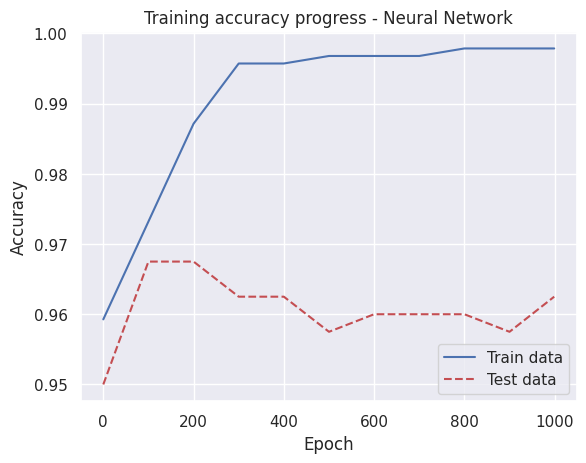

In [350]:
# Select best model from expereiment 2
best_preds = max(results_nn_2, key=lambda a:a['classification_report']['1.0']['f1-score'])

# Plot training accuracy
# sns.reset_orig()
sns.set_theme()
plt.plot([d['epoch'] for d in best_preds['acc_prog']], [d['train_acc'] for d in best_preds['acc_prog']], label='Train data')
plt.plot([d['epoch'] for d in best_preds['acc_prog']], [d['test_acc'] for d in best_preds['acc_prog']], 'r--', label='Test data')
plt.title('Training accuracy progress - Neural Network')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim(0,1)
plt.legend()
plt.show()

### 5.1.3 Αξιολόγηση - Νευρωνικό Δίκτυο
Από τις επαναλήψεις του πειράματος παίρνουμε το καλύτερο μοντέλο και υπολογίζουμε διάφορες μετρικές όπως ο πίνακας σύγχησης και οι καμπύλες ROC

Καμπύλη ROC

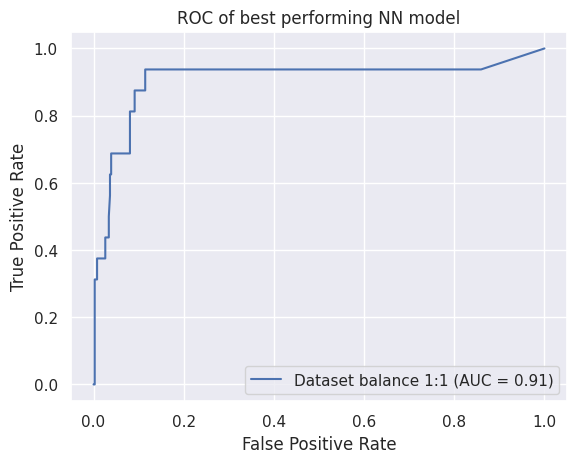

In [348]:
y_true = best_preds['true'].flatten()
y_pred = best_preds['preds'].flatten()

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# sns.reset_orig()
sns.set_theme()
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Dataset balance ' + best_performing_model['balance'])
display.plot()
plt.title('ROC of best performing NN model')
plt.show()

Πίνακας σύγχησης

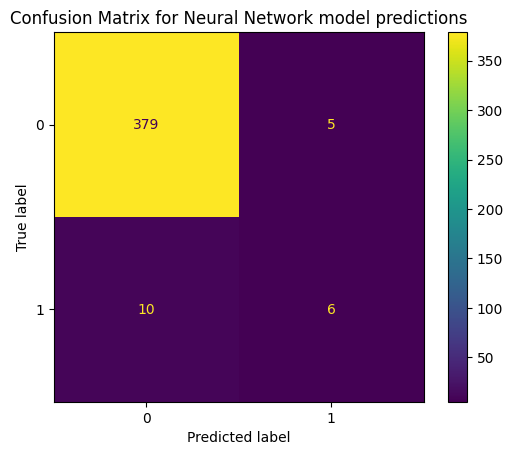

In [345]:
y_test, y_test_pred = torch.round(torch.tensor((best_preds['true']))), torch.round(torch.tensor((best_preds['preds'])))
cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.reset_orig()
# sns.set_theme()
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()
plt.title('Confusion Matrix for Neural Network model predictions')
plt.show()

Αναφορά ταξινόμησης καλύτερου μοντέλου.

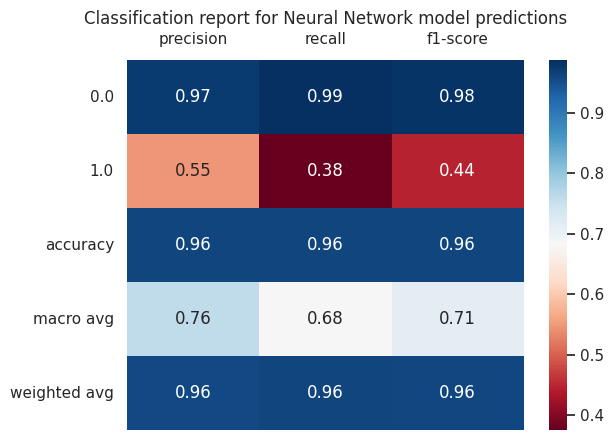

In [335]:
clf_report = classification_report(y_test, y_test_pred, output_dict=True)
# sns.reset_orig()
sns.set_theme()
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap=colormaps['RdBu'])
plt.title('Classification report for Neural Network model predictions')
plt.tick_params(labelbottom = False, labeltop=True)
plt.show()

## 5.2 K-Nearest Neighbors classification model

In [144]:
df_knn = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
       'rotten_tomatoes_audience', 'metacritic_audience',
       'opening_weekend_($million)', 'domestic_gross_($million)',
       'foreign_gross_($million)', 'budget_($million)', 'oscar_winners']]

In [145]:
df_oscar_winners = df_knn[df_knn["oscar_winners"] == 1]
print(df_oscar_winners.shape)

df_rest = df_knn[df_knn["oscar_winners"] != 1]
df_rest = df_rest.sample(n=110, random_state=42)
print(df_rest.shape)

df_knn_small = pd.concat([df_oscar_winners, df_rest], axis=0)
print(df_knn_small.shape)

(54, 9)
(110, 9)
(164, 9)


In [146]:
X_knn = df_knn_small.iloc[:, :-1].values
y_knn = df_knn_small.iloc[:, -1].values

In [147]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.2, stratify=y_knn, random_state=42)

In [148]:
scaler = StandardScaler()

scaler.fit(X_train_knn)
X_train_knn = scaler.transform(X_train_knn)

X_test_knn = scaler.transform(X_test_knn)

In [149]:
k_values = [i for i in range (2,31)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_knn, y_knn, cv=5)
    scores.append(np.mean(score))

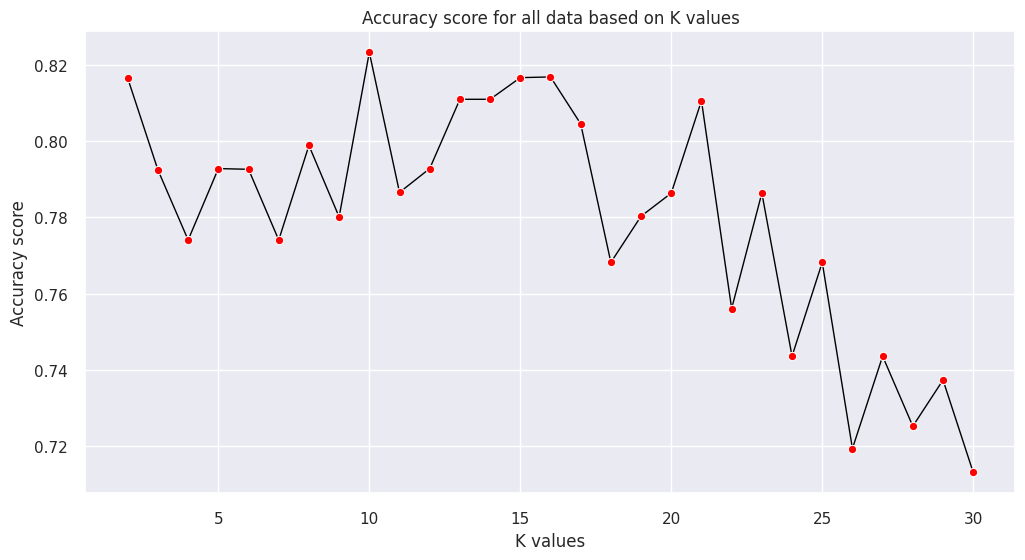

In [150]:
plt.figure(figsize=(12,6))
sns.lineplot(x = k_values, y = scores, marker='o', markerfacecolor='red', color='black', linewidth=1).set(title='Accuracy score for all data based on K values',
                                                                                       xlabel='K values',
                                                                                       ylabel='Accuracy score')
sns.set_theme(style='darkgrid', font_scale=1.25)
# sns.set(rc={'figure.facecolor':'lightgrey'})

In [151]:
best_index = np.argmax(scores)
best_k = k_values[best_index]
best_k

10

In [152]:
results_knn = []
for i in range(10):
    X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.2, stratify=y_knn)

    classifier_small = KNeighborsClassifier(n_neighbors=best_k)

    classifier_small.fit(X_train_knn, y_train_knn)

    y_preds_knn_small_prob = classifier_small.predict_proba(X_test_knn)
    
    y_preds_knn_small = classifier_small.predict(X_test_knn)        

    accuracy = metrics.accuracy_score(y_test_knn, y_preds_knn_small)

    recall = metrics.recall_score(y_test_knn, y_preds_knn_small, average='weighted')

    precision = metrics.precision_score(y_test_knn, y_preds_knn_small, average='weighted')

    f1 = metrics.f1_score(y_test_knn, y_preds_knn_small, average='weighted')

    results_knn.append({'model' :f'model_knn_{i}', 
                    'accuracy' : accuracy,
                    'recall' : recall,
                    'precision' : precision,
                    'f1' : f1,
                    'probs' : [x.max() for x in y_preds_knn_small_prob],
                    'preds' : y_preds_knn_small, 
                    'pred_oscar_count' : int(y_preds_knn_small.sum().item()), 
                    'truth_oscar_count' : int(y_test_knn.sum().item()) })

In [154]:
sum = 0
for item in results_knn:
    sum += item['accuracy']

avg_accuracy = sum / len(results_knn)
print(f"Average accuracy is: {avg_accuracy}")

Average accuracy is: 0.7787878787878789


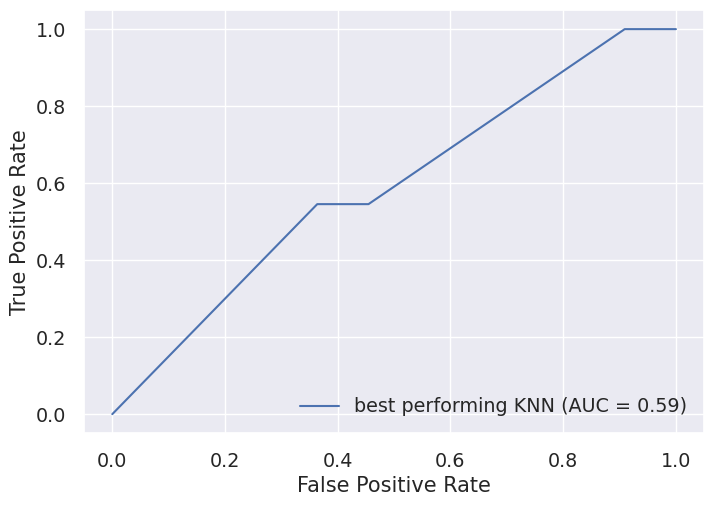

In [155]:
max_acc = 0
max_preds = []
for item in results_knn:
    if item['accuracy'] > max_acc:
        max_acc = item['accuracy']
        max_preds = item['probs']


# best = max(results_knn, key=lambda x:x['accuracy'])

fpr, tpr, thresholds = metrics.roc_curve(y_test_knn, max_preds, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='best performing KNN')
display.plot()
plt.show()

## 5.3 Decision Tree

In [157]:
df_dt = df_cl[['metacritic_critics', 'opening_weekend_($million)',
               'domestic_gross_($million)', 'foreign_gross_($million)',
               'oscar_winners']]

In [164]:
df_oscar_winners = df_dt[df_dt["oscar_winners"] == 1]
print(df_oscar_winners.shape)

df_rest = df_dt[df_dt["oscar_winners"] != 1]
df_rest = df_rest.sample(n=54, random_state=42)
print(df_rest.shape)

df_dt_balanced = pd.concat([df_oscar_winners, df_rest], axis=0)
print(df_dt_balanced.shape)

(54, 5)
(54, 5)
(108, 5)


In [165]:
X_dt = df_dt_balanced.iloc[:, :-1].values
y_dt = df_dt_balanced.iloc[:, -1].values

In [171]:
results_dt = []
for i in range(10):
    X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size = 0.2, stratify=y_dt)

    # print(X_train_dt.shape, X_test_dt.shape, y_train_dt.shape, y_test_dt.shape)
    # print(X_train_dt[:3])
    # print("\n")
    # print(y_train_dt[:3])

    # dt_classifier = DecisionTreeClassifier()

    dt_classifier = DecisionTreeClassifier()

    dt_classifier.fit(X_train_dt, y_train_dt)

    dt_preds = dt_classifier.predict(X_test_dt)

    accuracy = metrics.accuracy_score(y_test_dt, dt_preds)

    recall = metrics.recall_score(y_test_dt, dt_preds, average='weighted')

    precision = metrics.precision_score(y_test_dt, dt_preds, average='weighted')

    f1 = metrics.f1_score(y_test_dt, dt_preds, average='weighted')

    results_dt.append({'model' : f'model_dt_{i}',
                    'accuracy' : accuracy,
                    'recall' : recall,
                    'precision' : precision,
                    'f1' : f1,
                    'preds' : dt_preds, 
                    'pred_oscar_count' : int(dt_preds.sum().item()), 
                    'truth_oscar_count' : int(y_test_dt.sum().item()) })

In [167]:
sum = 0
for item in results_dt:
    sum += item['accuracy']

avg_accuracy = sum / len(results_dt)
print(f"Average accuracy is: {avg_accuracy}")

Average accuracy is: 0.759090909090909


In [175]:
len(y_test_dt), len(max_preds)

(22, 33)

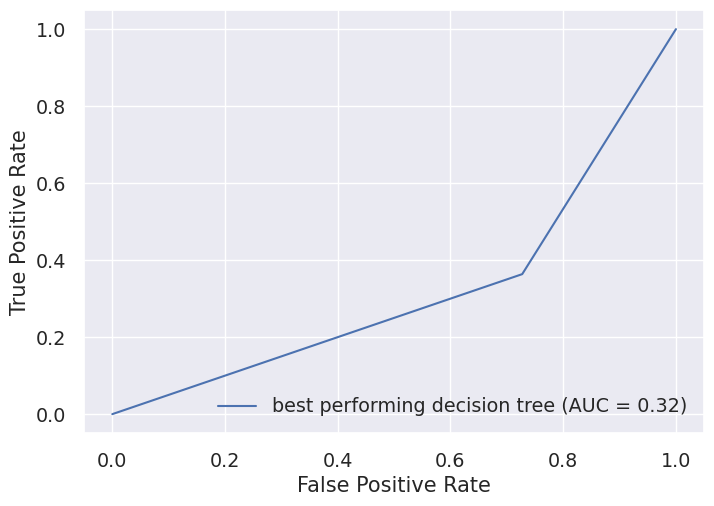

In [177]:
best = max(results_dt, key=lambda x:x['accuracy'])

fpr, tpr, thresholds = metrics.roc_curve(y_test_dt, best['preds'], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='best performing decision tree')
display.plot()
plt.show()

## 5.4. Σύγκριση μοντέλων

### 5.4.x Model comparisson graphs

- Lineplot: (line for each model)
- Barplot: Recall for each n:1 balance (average for n-folds) x=number of n:1 balance datasets y=avg recall of n-fold
- ROC curves

In [ ]:
# lineplot
# 1st experiment

exp_a_data = [{
    'model': 'neural_network',
    'accuracy' : [],
    'recall' : [],
    'f1' : [],
    'n_balance_datasets' : int
    }, {
    'model': 'knearest',
    'accuracy' : [],
    'recall' : [],
    'f1' : [],
    'n_balance_datasets' : int
    },{
    'model': 'tree',
    'accuracy' : [],
    'recall' : [],
    'f1' : [],
    'n_balance_datasets' : int
    }]

In [ ]:
# barplot
# 2nd experiment

exp_b_data = [{
    'model': 'neural network',
    'avg_recall' : float,
    'n_repetitions' : int,
    'fpr' : fpr,
    'tpr' : tpr
    }, ....]
